In [1]:
#import all necessary packages
import os
import sys
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import math
import random
import collections
import scipy.io as sio
import scipy.stats as st

import scipy.io as sio
from sklearn.metrics import confusion_matrix, mean_absolute_error
import time
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# load dataframe that includes logistic regression predictions of all models (image only, clinical vars,
# combined models, etc.; file contains info for both MRI and X-ray models)
label_df = pd.read_csv('labels/TKR_labels_all_pipeline_versions.csv')
label_df = label_df.drop(['Unnamed: 0'],axis = 1)
label_df = label_df.set_index('ID_Side_Visit')

In [4]:
label_df

TKR_in_5_years  OA_status  Inferred_KLG  set  \
ID_Side_Visit                                                   
9000099_LEFT_0                0          1             3    0   
9000099_RIGHT_1               0          1             2    0   
9000099_RIGHT_3               0          1             2    0   
9000099_LEFT_3                0          1             4    0   
9000099_RIGHT_6               0          1             2    0   
9000296_RIGHT_0               0          1             2    2   
9000296_RIGHT_1               0          1             2    2   
9000296_RIGHT_5               0          1             2    2   
9000296_RIGHT_6               0          1             2    2   
9000296_LEFT_6                0          1             3    2   
9000622_RIGHT_0               0          0             1    0   
9000622_LEFT_0                0          0             1    0   
9000622_RIGHT_1               0          0             1    0   
9000622_LEFT_1                0          0             1    0   
9000798_RIGHT_0               0          0             1    2   
9000798_LEFT_0                0          1             4    2   
9000798_RIGHT_1               0          0             1    2   
9000798_LEFT_1                0          1             4    2   
9000798_RIGHT_3               0          0             1    2   
9000798_LEFT_3                0          1             4    2   
9000798_RIGHT_5               0          0             1    2   
9000798_LEFT_5                0          1             4    2   
9000798_RIGHT_6               0          0             1    2   
9000798_LEFT_6                0          1             4    2   
9001104_RIGHT_0               0          1             3    0   
9001104_LEFT_0                0          0             1    0   
9001104_RIGHT_1               0          1             3    0   
9001104_LEFT_1                0          0             1    0   
9001400_RIGHT_0               0          0             1    0   
9001400_LEFT_0                0          0             1    0   
...                         ...        ...           ...  ...   
9967719_LEFT_0                1          1             4    0   
9967719_LEFT_1                1          1             4    0   
9967719_LEFT_3                1          1             4    0   
9967728_LEFT_3                1          1             3    0   
9967728_LEFT_5                1          1             3    0   
9967728_LEFT_6                1          1             3    0   
9967728_LEFT_8                1          1             3    0   
9971710_LEFT_0                1          1             4    1   
9971710_LEFT_1                1          1             4    1   
9973713_LEFT_0                1          1             4    0   
9973713_LEFT_1                1          1             4    0   
9973713_LEFT_3                1          1             4    0   
9976720_LEFT_0                1          1             3    0   
9976720_LEFT_1                1          1             4    0   
9976720_LEFT_3                1          1             4    0   
9976720_LEFT_5                1          1             3    0   
9988891_RIGHT_0               1          1             3    0   
9988891_RIGHT_1               1          1             4    0   
9991313_LEFT_0                1          1             4    0   
9991313_LEFT_1                1          1             4    0   
9991313_LEFT_3                1          1             4    0   
9991313_LEFT_5                1          1             4    0   
9992318_LEFT_3                1          1             4    2   
9992318_LEFT_5                1          1             4    2   
9992318_LEFT_6                1          1             4    2   
9992318_LEFT_8                1          1             4    2   
9993650_RIGHT_3               1          1             2    1   
9993650_RIGHT_5               1          1             3    1   
9993650_RIGHT_6               1          1          

In [5]:
# Subsequent few cells all entail removing duplicate entries from the dataframe only within validation and 
# test sets. These cells also generate a list for each of training, validation, and test that stores indices
# of entries within each dataset that were of a given KL grade (i.e. within the list, the first entry was
# a list of all indices where entries in the given dataset were of KL = 0; the second entry in the list was
# where all entries in the dataset were of KL = 1, etc.). This is critical for displaying performance
# stratified by KL grade/OA status

train_ind = np.where(label_df.set == 0)[0]
val_ind   = np.where(label_df.set == 1)[0]
test_ind  = np.where(label_df.set == 2)[0]

In [6]:
# Separate training data into labels and non-labels
train_set_full   = label_df.iloc[train_ind]
train_set_labels = train_set_full['TKR_in_5_years']
train_set_full   = train_set_full.drop(columns = ['TKR_in_5_years'])

In [7]:
# Separate validation data into labels and non-labels
val_set_full   = label_df.iloc[val_ind]
val_set_labels = val_set_full['TKR_in_5_years']
val_set_full   = val_set_full.drop(columns = ['TKR_in_5_years'])

# Remove duplicated entries within validation data
val_patients_found = []
val_patient_ind = []

for i in range(len(val_set_full.index)):
    if val_set_full.index[i] in val_patients_found:
        val_patient_ind = val_patient_ind
    else:
        val_patients_found.append(val_set_full.index[i])
        val_patient_ind.append(i)

val_set_full = val_set_full.iloc[val_patient_ind]
val_set_labels = val_set_labels.iloc[val_patient_ind]

In [8]:
# Separate test data into labels and non-labels
test_set_full   = label_df.iloc[test_ind]
test_set_labels = test_set_full['TKR_in_5_years']
test_set_full   = test_set_full.drop(columns = ['TKR_in_5_years'])

# Remove duplicated entries in test data
test_patients_found = []
test_patient_ind = []

for i in range(len(test_set_full.index)):
    if test_set_full.index[i] in test_patients_found:
        test_patient_ind = test_patient_ind
    else:
        test_patients_found.append(test_set_full.index[i])
        test_patient_ind.append(i)

test_set_full   = test_set_full.iloc[test_patient_ind]
test_set_labels = test_set_labels.iloc[test_patient_ind]

In [9]:
# Develop an KL classification indicies list for training data
train_ind = np.where(label_df.set == 0)[0]
train_kl_cats = []
for i in range(5):
    curr_ind = np.where(train_set_full['Inferred_KLG'] == i)[0]
    train_kl_cats.append(curr_ind)
    
train_kl_cats.append(np.where((np.round(train_set_full['Inferred_KLG'].values*0.01) == 0) == True)[0])

train_kl_cats

[array([   41,    42,    43, ..., 44262, 44311, 44325]),
 array([    5,     6,     7, ..., 44348, 44349, 44387]),
 array([    1,     2,     4, ..., 44395, 44396, 44397]),
 array([    0,     9,    11, ..., 44413, 44416, 44417]),
 array([    3,    26,    29, ..., 44420, 44421, 44422]),
 array([    0,     1,     2, ..., 44420, 44421, 44422])]

In [10]:
# Develop an KL classification indicies list for validation data
val_ind = np.where(label_df.set == 1)[0]
val_kl_cats = []
for i in range(5):
    curr_ind = np.where(val_set_full['Inferred_KLG'] == i)[0]
    val_kl_cats.append(curr_ind)
    
val_kl_cats.append(np.where((np.round(val_set_full['Inferred_KLG'].values*0.01) == 0) == True)[0])

val_kl_cats

[array([   3,    5,   10, ..., 7017, 7018, 7019]),
 array([   1,    8,    9, ..., 7040, 7041, 7078]),
 array([  12,   14,   16, ..., 7109, 7110, 7111]),
 array([   0,    2,    4,    6,    7,   27,   29,   31,   33,   34,   35,
         131,  152,  154,  156,  158,  159,  161,  162,  163,  164,  183,
         185,  187,  189,  191,  308,  309,  310,  311,  312,  313,  314,
         315,  316,  317,  355,  356,  357,  358,  394,  396,  398,  400,
         402,  429,  431,  433,  434,  435,  436,  437,  438,  439,  469,
         470,  480,  487,  488,  491,  493,  494,  495,  496,  497,  498,
         499,  500,  501,  502,  503,  504,  505,  506,  526,  528,  529,
         530,  532,  533,  534,  535,  544,  563,  565,  567,  569,  570,
         617,  641,  642,  643,  644,  645,  646,  647,  648,  649,  650,
         687,  689,  691,  693,  695,  713,  715,  717,  718,  744,  753,
         765,  766,  767,  768,  853,  855,  857,  899,  900,  901,  902,
         903,  904,  905,  906,  

In [11]:
# Develop an KL classification indicies list for test data
test_ind = np.where(label_df.set == 2)[0]
test_kl_cats = []
for i in range(5):
    curr_ind = np.where(test_set_full['Inferred_KLG'] == i)[0]
    test_kl_cats.append(curr_ind)
    
test_kl_cats.append(np.where((np.round(test_set_full['Inferred_KLG'].values*0.01) == 0) == True)[0])

test_kl_cats

[array([  16,   18,   20, ..., 5205, 5206, 5207]),
 array([   5,    7,    9,   11,   13,   21,   29,   90,   92,  112,  114,
         116,  118,  120,  167,  169,  171,  173,  174,  179,  181,  184,
         185,  186,  187,  188,  189,  190,  191,  192,  194,  196,  198,
         199,  231,  233,  235,  237,  239,  242,  244,  246,  248,  260,
         261,  262,  263,  264,  265,  266,  286,  287,  288,  289,  290,
         291,  292,  293,  294,  295,  306,  308,  315,  316,  317,  318,
         319,  320,  321,  322,  323,  324,  325,  327,  329,  331,  334,
         336,  338,  340,  342,  345,  363,  383,  415,  417,  419,  434,
         436,  437,  438,  440,  442,  446,  447,  448,  449,  450,  451,
         452,  453,  464,  465,  466,  467,  507,  508,  510,  512,  514,
         515,  516,  538,  552,  553,  554,  556,  644,  645,  654,  656,
         658,  660,  662,  664,  665,  666,  667,  668,  669,  670,  671,
         672,  673,  682,  691,  693,  695,  697,  698,  699,

In [12]:
# Separate KL grades of validation and test data
val_kl  = val_set_full['Inferred_KLG'].values
test_kl = test_set_full['Inferred_KLG'].values

In [13]:
# Extract raw predictions of validation, training, and test data; round raw predictions for final
# predictions as well (both are required for different subsequent calculations)
image_preds_float = label_df.loc[label_df.set == 1,'Image_Preds_MRI'].values[val_patient_ind]
image_preds       = np.round(image_preds_float)

image_preds_tr_float = label_df.loc[label_df.set == 0,'Image_Preds_MRI'].values
image_preds_tr       = np.round(image_preds_tr_float)

image_preds_test_float = label_df.loc[label_df.set == 2,'Image_Preds_MRI'].values[test_patient_ind]
image_preds_test       = np.round(image_preds_test_float)

In [14]:
# the following function calculates means and standard deviations across bootstrapped samples of accuracy,
# sensitivity, and specificity, stratified both by KL grade and OA status. Inputs are an array of rounded
# class predictions, an array of the float outputs of either an image-only or logistic regression model,
# a list of the kl grades of each entry within the dataset of interest (kl_list), a list of lists in which
# the first entry is all entries with kl grades of 0, the second is all entries with kl grades of 1, and so
# on, and the labels. Outputs of this function are used to generate the some of the model performance tables
# seen in the paper, as well as providing some of the raw data used to make ROC curve plots.

def calculate_bootstrapped_stats(rounded_preds, float_preds, curr_labels, kl_list, kl_cats):
    performance_by_KL_TKR = np.zeros([6,2])
    for i in range(6):
        non_TKR = (curr_labels[kl_cats[i]] == 0).sum()
        TKR     = (curr_labels[kl_cats[i]] == 1).sum()
        performance_by_KL_TKR[i,:] = [non_TKR,TKR]

    performance_by_OA_TKR = np.zeros([4,2])
    oa_grades = [[0,1],[2,3],[4],[5]]
    for i in range(len(oa_grades)):
        non_TKR = 0
        TKR = 0
        for n in range(len(oa_grades[i])):
            non_TKR += (curr_labels[kl_cats[oa_grades[i][n]]] == 0).sum()
            TKR     += (curr_labels[kl_cats[oa_grades[i][n]]] == 1).sum()
        performance_by_OA_TKR[i,:] = [non_TKR,TKR]
    
    OA_performance  = [] 
    KL_performance  = []
    #OA and KL performance lists store a performance table for each of 100 bootstrapped sampled. The performance
    #tables show accuracy, sensitivity, specificity, number of non-TKR cases, and number of TKR cases for
    #patients with no OA, moderate OA, severe OA, and all patients (for OA performance table; for KL, those
    #parameters are tracked against patients with each KL classification and all patients)

    AUC_performance = []
    #AUC_performance_val tracks the ROC AUC of each bootstrapped sample. Allows for CI calculations later on

    roc_raw_data = [[] for i in range(3)]
    
    for k in tqdm_notebook(range(100)):
        repeat_split = 1
        #Generate a bootstrapped sample while ensuring that any bootstrapped sample has at least one patient in 
        #every KL classification
        while repeat_split == 1:
            num_samples = int(np.round(len(rounded_preds)*1))
            entries = np.random.choice(range(len(rounded_preds)),num_samples)

            entries = np.array(entries)
            labels = curr_labels[entries]
            im_preds = rounded_preds[entries]

            kl_of_data = []
            for i in range(5):
                curr_ind = np.where(kl_list[entries] == i)[0]
                kl_of_data.append(curr_ind)
            kl_of_data.append(np.where((np.round(kl_list[entries]*0.01) == 0) == True)[0])

            repeat_split = 0
            for i in range(5):
                if len(np.where(labels[kl_of_data[i]] == 1)[0]) == 0:
                    repeat_split = 1

        #calculate and append KL performance table
        performance_by_KL_im = np.zeros([6,5])
        for i in range(6):
            acc = len(np.where((im_preds[kl_of_data[i]] == 
                    labels[kl_of_data[i]]))[0])/(len(kl_of_data[i]))
            sens = round(len(np.intersect1d(np.where(im_preds[kl_of_data[i]] == 1),
                    np.where(labels[kl_of_data[i]] == 1)))/
                        len(np.where(labels[kl_of_data[i]] == 1)[0]),4)
            spec = round(len(np.intersect1d(np.where(im_preds[kl_of_data[i]] == 0),
                    np.where(labels[kl_of_data[i]] == 0)))/
                         len(np.where(labels[kl_of_data[i]] == 0)[0]),4)
            non_TKR = (labels[kl_of_data[i]] == 0).sum()
            TKR = (labels[kl_of_data[i]] == 1).sum()
            performance_by_KL_im[i,:] = [acc,sens,spec,non_TKR,TKR]

        KL_performance.append(performance_by_KL_im)

        #calculate and append OA performance table
        performance_by_OA_im = np.zeros([4,5])
        oa_grades = [[0,1],[2,3],[4],[5]]
        for i in range(len(oa_grades)):
            non_TKR = 0
            TKR = 0
            acc = [0,0]
            sens = [0,0]
            spec = [0,0]
            for j in range(len(oa_grades[i])):
                acc[0] += len(np.where((im_preds[kl_of_data[oa_grades[i][j]]] 
                                        == labels[kl_of_data[oa_grades[i][j]]]))[0]) 
                acc[1] += len(kl_of_data[oa_grades[i][j]])
                sens[0] += len(np.intersect1d(np.where(im_preds[kl_of_data[oa_grades[i][j]]] == 1),
                    np.where(labels[kl_of_data[oa_grades[i][j]]] == 1)))
                sens[1] += len(np.where(labels[kl_of_data[oa_grades[i][j]]] == 1)[0])
                spec[0] += len(np.intersect1d(np.where(im_preds[kl_of_data[oa_grades[i][j]]] == 0),
                    np.where(labels[kl_of_data[oa_grades[i][j]]] == 0)))
                spec[1] += len(np.where(labels[kl_of_data[oa_grades[i][j]]] == 0)[0])
                non_TKR += (labels[kl_of_data[oa_grades[i][j]]] == 0).sum() 
                TKR += (labels[kl_of_data[oa_grades[i][j]]] == 1).sum() 
            performance_by_OA_im[i,:] = [acc[0]/acc[1],sens[0]/sens[1],spec[0]/spec[1],non_TKR,TKR]

        OA_performance.append(performance_by_OA_im)

        #calculate and append AUC
        fpr, tpr, thresholds = metrics.roc_curve(labels,float_preds[entries])
        AUC_performance.append(roc_auc_score(labels,float_preds[entries]))
        roc_raw_data[0].append(fpr)
        roc_raw_data[1].append(tpr)
        roc_raw_data[2].append(roc_auc_score(labels,float_preds[entries]))
        
    # from OA performance arrays, create a new all_OA_data array that is a list of lists: this is set up such
    # that the first entry in the all_OA_data list is a list of accuracies of all bootstrapped samples at early
    # stage OA; in this manner, a list of lists is create that appends all tracked parameters across  
    # bootstrapped samples such that parameters like mean and standard deviation can more easily be calculated

    count = 0
    all_OA_data = [[] for m in range(OA_performance[0].shape[0]*3)]
    for i in range(OA_performance[0].shape[0]):
        for n in range(3):
            for k in range(100):
                all_OA_data[count].append(OA_performance[k][i][n])
            count+=1

    # all_KL_data list is constructed with the same structure 
    count = 0
    all_KL_data = [[] for m in range(KL_performance[0].shape[0]*3)]
    for i in range(KL_performance[0].shape[0]):
        for n in range(3):
            for k in range(100):
                all_KL_data[count].append(KL_performance[k][i][n])
            count+=1

    # calculate mean and standard deviation within OA stratifications/KL stratifications across bootstrapped samples
    all_OA_stats = []
    for i in range(len(all_OA_data)):
        all_OA_stats.append([np.mean(all_OA_data[i]),np.std(all_OA_data[i])/math.sqrt(len(OA_performance))])

    all_KL_stats = []
    for i in range(len(all_KL_data)):
        all_KL_stats.append([np.mean(all_KL_data[i]),np.std(all_KL_data[i])/math.sqrt(len(KL_performance))])


    # consolidate means and standard deviations into independent arrays summarizing these descriptive statistics
    # by KL and by OA status
    performance_by_KL = np.zeros([6,5])
    performance_by_KL_std = np.zeros([6,5])
    count = 0

    for i in range(KL_performance[0].shape[0]):
        for k in range(3):
            performance_by_KL[i][k] = all_KL_stats[count][0]
            performance_by_KL_std[i][k] = all_KL_stats[count][1]
            count+=1

    performance_by_KL[:,3:5]     = performance_by_KL_TKR
    performance_by_KL_std[:,3:5] = performance_by_KL_TKR

    performance_by_OA = np.zeros([4,5])
    performance_by_OA_std = np.zeros([4,5])
    count = 0

    for i in range(OA_performance[0].shape[0]):
        for k in range(3):
            performance_by_OA[i][k] = all_OA_stats[count][0]
            performance_by_OA_std[i][k] = all_OA_stats[count][1]
            count+=1

    performance_by_OA[:,3:5]     = performance_by_OA_TKR
    performance_by_OA_std[:,3:5] = performance_by_OA_TKR
    
    return performance_by_OA, performance_by_OA_std, performance_by_KL, performance_by_KL_std, AUC_performance, roc_raw_data

In [15]:
#calculate bootstrapped statistics for image-only models on validation data
performance_by_OA, performance_by_OA_std, performance_by_KL, performance_by_KL_std, \
AUC_performance_val, roc_raw_data_val = calculate_bootstrapped_stats(image_preds, image_preds_float, \
                                                             val_set_labels, val_kl, val_kl_cats)

In [16]:
# Consolidate validation performances across bootstrapped samples in an easier to read dataframe
val_KL_performance = np.zeros([6,8])
val_KL_performance[:,0] = performance_by_KL[:,0]
val_KL_performance[:,1] = performance_by_KL_std[:,0]
val_KL_performance[:,2] = performance_by_KL[:,1]
val_KL_performance[:,3] = performance_by_KL_std[:,1]
val_KL_performance[:,4] = performance_by_KL[:,2]
val_KL_performance[:,5] = performance_by_KL_std[:,2]
val_KL_performance[:,6] = performance_by_KL[:,3]
val_KL_performance[:,7] = performance_by_KL[:,4]

performance_kl_df_img = pd.DataFrame(data=val_KL_performance)
performance_kl_df_img.index.name = 'KL_Grade'
performance_kl_df_img.index = ['0','1','2','3','4','ALL']
performance_kl_df_img.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']
print('Image Only Model, Validation Data')
performance_kl_df_img

Image Only Model, Validation Data


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  Specificity  Spec.Std.  \
0    0.959570  0.000394     0.292286   0.032716     0.960234   0.000383   
1    0.916853  0.000819     0.299140   0.015734     0.921915   0.000782   
2    0.809764  0.000968     0.627770   0.008054     0.813189   0.000931   
3    0.457448  0.001708     0.948806   0.002974     0.422591   0.001836   
4    0.408501  0.003206     1.000000   0.000000     0.082954   0.002073   
ALL  0.828521  0.000515     0.880359   0.002282     0.826971   0.000524   

     Non_TKR    TKR  
0     2879.0    3.0  
1     1239.0   10.0  
2     1768.0   34.0  
3      843.0   59.0  
4      182.0   98.0  
ALL   6911.0  204.0

In [17]:
val_OA_performance = np.zeros([4,8])
val_OA_performance[:,0] = performance_by_OA[:,0]
val_OA_performance[:,1] = performance_by_OA_std[:,0]
val_OA_performance[:,2] = performance_by_OA[:,1]
val_OA_performance[:,3] = performance_by_OA_std[:,1]
val_OA_performance[:,4] = performance_by_OA[:,2]
val_OA_performance[:,5] = performance_by_OA_std[:,2]
val_OA_performance[:,6] = performance_by_OA[:,3]
val_OA_performance[:,7] = performance_by_OA[:,4]

performance_oa_df_img = pd.DataFrame(data=val_OA_performance)
performance_oa_df_img.index.name = 'KL_Grade'
performance_oa_df_img.index = ['None','Moderate','Severe','ALL']
performance_oa_df_img.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']
print('Image Only Model, Validation Data')
performance_oa_df_img

Image Only Model, Validation Data


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  Specificity  Spec.Std.  \
None      0.946621  0.000392     0.295853   0.013681     0.948675   0.000376   
Moderate  0.691961  0.000913     0.834642   0.003776     0.686895   0.000928   
Severe    0.408501  0.003206     1.000000   0.000000     0.082956   0.002073   
ALL       0.828521  0.000515     0.880360   0.002282     0.826972   0.000524   

          Non_TKR    TKR  
None       4118.0   13.0  
Moderate   2611.0   93.0  
Severe      182.0   98.0  
ALL        6911.0  204.0

AUC: 0.9144 +/- 0.0188, p < 0.05


Text(0, 0.5, 'False negative rate')

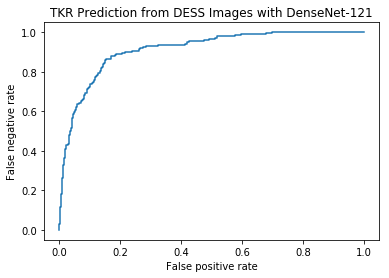

In [18]:
# show ROC curve for validation data and display 95% confidence interval of AUC calculated from bootstrapped
# samples

fpr_im, tpr_im, thresholds = metrics.roc_curve(val_set_labels,image_preds_float)
print('AUC: '+ str(np.round(np.mean(AUC_performance_val),4)) + ' +/- '+str(np.round(st.norm.ppf(.975)*np.std(AUC_performance_val),4)) + ', p < 0.05')

plt.plot(fpr_im,tpr_im)
plt.title('TKR Prediction from DESS Images with DenseNet-121')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')

In [19]:
#calculate bootstrapped statistics for image-only models on test data
performance_by_OA_test, performance_by_OA_std_test, performance_by_KL_test, performance_by_KL_std_test, \
AUC_performance_test, roc_raw_data_test = calculate_bootstrapped_stats(image_preds_test, \
                            image_preds_test_float, test_set_labels, test_kl, test_kl_cats)

In [20]:
test_KL_performance = np.zeros([6,8])
test_KL_performance[:,0] = performance_by_KL_test[:,0]
test_KL_performance[:,1] = performance_by_KL_std_test[:,0]
test_KL_performance[:,2] = performance_by_KL_test[:,1]
test_KL_performance[:,3] = performance_by_KL_std_test[:,1]
test_KL_performance[:,4] = performance_by_KL_test[:,2]
test_KL_performance[:,5] = performance_by_KL_std_test[:,2]
test_KL_performance[:,6] = performance_by_KL_test[:,3]
test_KL_performance[:,7] = performance_by_KL_test[:,4]

performance_kl_df_img_test = pd.DataFrame(data=test_KL_performance)
performance_kl_df_img_test.index.name = 'KL_Grade'
performance_kl_df_img_test.index = ['0','1','2','3','4','ALL']
performance_kl_df_img_test.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']
print('Image Only Model, Test Data')
performance_kl_df_img_test

Image Only Model, Test Data


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  Specificity  Spec.Std.  \
0    0.955824  0.000460     0.183884   0.020422     0.957794   0.000463   
1    0.941515  0.000889     1.000000   0.000000     0.941110   0.000895   
2    0.787846  0.001193     0.620164   0.012121     0.790351   0.001222   
3    0.511081  0.001893     0.841350   0.004017     0.480958   0.001931   
4    0.343852  0.003436     0.981055   0.001627     0.089428   0.002407   
ALL  0.821162  0.000563     0.849265   0.003040     0.820334   0.000586   

     Non_TKR    TKR  
0     1930.0    5.0  
1      962.0    7.0  
2     1354.0   20.0  
3      702.0   63.0  
4      141.0   57.0  
ALL   5089.0  152.0

In [21]:
test_OA_performance = np.zeros([4,8])
test_OA_performance[:,0] = performance_by_OA_test[:,0]
test_OA_performance[:,1] = performance_by_OA_std_test[:,0]
test_OA_performance[:,2] = performance_by_OA_test[:,1]
test_OA_performance[:,3] = performance_by_OA_std_test[:,1]
test_OA_performance[:,4] = performance_by_OA_test[:,2]
test_OA_performance[:,5] = performance_by_OA_std_test[:,2]
test_OA_performance[:,6] = performance_by_OA_test[:,3]
test_OA_performance[:,7] = performance_by_OA_test[:,4]

performance_oa_df_img_test = pd.DataFrame(data=test_OA_performance)
performance_oa_df_img_test.index.name = 'OA_Status'
performance_oa_df_img_test.index = ['None','Moderate','Severe','ALL']
performance_oa_df_img_test.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']
print('Image Only Model, Test Data')
performance_oa_df_img_test

Image Only Model, Test Data


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  Specificity  Spec.Std.  \
None      0.951062  0.000458     0.654193   0.014420     0.952255   0.000462   
Moderate  0.689328  0.001048     0.788306   0.004220     0.685315   0.001103   
Severe    0.343852  0.003436     0.981054   0.001627     0.089432   0.002407   
ALL       0.821162  0.000563     0.849261   0.003040     0.820331   0.000586   

          Non_TKR    TKR  
None       2892.0   12.0  
Moderate   2056.0   83.0  
Severe      141.0   57.0  
ALL        5089.0  152.0

AUC: 0.8852 +/- 0.0258, p < 0.05


Text(0, 0.5, 'False negative rate')

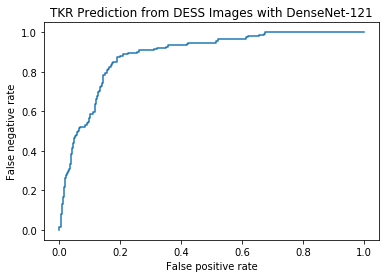

In [22]:
fpr_im_test, tpr_im_test, thresholds = metrics.roc_curve(test_set_labels,image_preds_test_float)

print('AUC: '+ str(np.round(np.mean(AUC_performance_test),4)) + ' +/- '+str(np.round(st.norm.ppf(.975)*np.std(AUC_performance_test),4)) + ', p < 0.05')

plt.plot(fpr_im_test,tpr_im_test)
plt.title('TKR Prediction from DESS Images with DenseNet-121')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')

In [23]:
# initialize arrays to store raw roc curve data of bootstrapped samples for patient only and integrated
# models
roc_raw_data_patient  = [[] for i in range(3)]
roc_raw_data_combined = [[] for i in range(3)]

In [24]:
# Loop below calculates performance tables and ROC AUC data for the non-imaging information only and
# integrated models, for validation and test data. 

# Initialize arrays to succintly feed labels and kl classifications during loop. Also initialize storage 
# arrays
full_test_val_labels = [val_set_labels.values, val_set_labels.values, 
                        test_set_labels.values,  test_set_labels.values]
full_test_val_kl = [val_kl_cats,val_kl_cats,test_kl_cats,test_kl_cats]
raw_kl = [val_kl,val_kl,test_kl,test_kl]

storage = []
storage_std = []
auc_data = []
AUC_performance_full = []
all_preds = []
iter_track = 0

for j_out in tqdm_notebook(range(4)):
    
    labels_for_test_or_val_outer = full_test_val_labels[j_out]
    kl_of_test_val_data_outer = full_test_val_kl[j_out]
    
    lr_preds = 0
    lr_preds_dec = 0
    
    # select a model type to use, and pick the appropriate data from label_df
    if j_out == 0:
        #with image, validation
        lr_preds_dec = label_df.loc[label_df.set == 1,'MRI_Hybrid_Model'].values[val_patient_ind]
        lr_preds = np.round(lr_preds_dec)
    elif j_out == 1:
        #without image, validation
        lr_preds_dec = label_df.loc[label_df.set == 1,'Clin_Model'].values[val_patient_ind]
        lr_preds = np.round(lr_preds_dec)
    elif j_out == 2:
        #with image, test
        lr_preds_dec = label_df.loc[label_df.set == 2,'MRI_Hybrid_Model'].values[test_patient_ind]
        lr_preds = np.round(lr_preds_dec)
    else:
        #without image, test
        lr_preds_dec = label_df.loc[label_df.set == 2,'Clin_Model'].values[test_patient_ind]
        lr_preds = np.round(lr_preds_dec)
    all_preds.append(lr_preds_dec)
    
    
    #calculate bootstrapped statistics for given model
    performance_by_OA, performance_by_OA_std, performance_by_KL, performance_by_KL_std, \
    AUC_performance, roc_raw_data = calculate_bootstrapped_stats(lr_preds, lr_preds_dec, \
                            labels_for_test_or_val_outer, raw_kl[j_out], kl_of_test_val_data_outer)
    
    #store roc curve data for desired models
    if iter_track == 2:
        roc_raw_data_combined = roc_raw_data
    if iter_track == 3:
        roc_raw_data_patient  = roc_raw_data
            
    fpr, tpr, thresholds = metrics.roc_curve(labels_for_test_or_val_outer,lr_preds_dec)
    auc_data.append([fpr,tpr,roc_auc_score(labels_for_test_or_val_outer,lr_preds_dec)])
    
    #store all data
    storage.append(performance_by_KL)
    storage.append(performance_by_OA)
    storage_std.append(performance_by_KL_std)
    storage_std.append(performance_by_OA_std)
    AUC_performance_full.append([np.mean(AUC_performance), np.std(AUC_performance)])
    iter_track += 1

In [25]:
# organize information collected during loop into format more amenable for display
labels = ['Validation, with Images','Validation, with Images',
          'Validation, no Images','Validation, no Images',
          'Test, with Images','Test, with Images',
          'Test, no Images','Test, no Images']

storage_dfs = []
storage_dfs_std = []

for i in range(len(storage)):
    if i%2 == 0:
        d = {'Acc': storage[i][:,0], 'Acc.Std.': storage_std[i][:,0], 'Sensitivity': storage[i][:,1], 
             'Sens.Std.': storage_std[i][:,1],'Specificity': storage[i][:,2],
             'Spec.Std.': storage_std[i][:,2],
             'Non_TKR_Cases': storage[i][:,3], 'TKR_Cases': storage[i][:,4]}
        performance_kl_df_lr = pd.DataFrame(data=d)
        performance_kl_df_lr = performance_kl_df_lr.rename(index={5: 'ALL'})
        performance_kl_df_lr.index.name = 'KL_Grade'
        storage_dfs.append(performance_kl_df_lr)
    else:
        d = {'Acc': storage[i][:,0], 'Acc.Std.': storage_std[i][:,0], 'Sensitivity': storage[i][:,1], 
             'Sens.Std.': storage_std[i][:,1], 'Specificity': storage[i][:,2],
             'Spec.Std.': storage_std[i][:,2],'Non_TKR_Cases': storage[i][:,3], 'TKR_Cases': storage[i][:,4]}
        performance_OA_df_lr = pd.DataFrame(data=d)
        performance_OA_df_lr = performance_OA_df_lr.rename(index={0: 'None', 1: 'Moderate',
                                                                 2: 'Severe', 3: 'All',})
        performance_OA_df_lr.index.name = 'OA_Status'
        storage_dfs.append(performance_OA_df_lr)

In [26]:
d = {'Acc': [], 'Acc.Std,': [], 'Sensitivity': [], 'Sens.Std.': [], 'Specificity': [], 
     'Spec.Std.': [],'Non_TKR_Cases': [], 'TKR_Cases': []}
full_val_df = pd.DataFrame(data = d)
indices = storage_dfs[2].index
for i in range(storage_dfs[0].shape[0]):
    full_val_df = full_val_df.append(storage_dfs[2].iloc[i])
    full_val_df = full_val_df.rename(index = {i: str(storage_dfs[2].index[i])+'_Patient_Only'})
    full_val_df = full_val_df.append(performance_kl_df_img.iloc[i])
    full_val_df = full_val_df.rename(index = {i: str(storage_dfs[0].index[i])+'_Image'})
    full_val_df = full_val_df.append(storage_dfs[0].iloc[i])
    full_val_df = full_val_df.rename(index = {i: str(storage_dfs[0].index[i])+'_Patient_And_Image'})

In [27]:
# display validation data performance table
print('Validation data full performance table')
full = np.zeros([6*3,8])
ind = []
for i in range(6):
    full[3*i,:] = storage_dfs[2].values[i,:]
    full[3*i+1,:] = performance_kl_df_img.values[i,:]
    full[3*i+2,:] = storage_dfs[0].values[i,:]
    full[3*i:3*i+3,0:6] = full[3*i:3*i+3,0:6] * 100
    if i < 5:
        ind.append('KL = '+str(i)+' - Patient Only')
        ind.append('KL = '+str(i)+' - Image Only')
        ind.append('KL = '+str(i)+' - Combined')
    else:
        ind.append('All - Patient Only')
        ind.append('All - Image Only')
        ind.append('All - Combined')

full = pd.DataFrame(data = full)

full.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']

full.index = ind

full


Validation data full performance table


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  \
KL = 0 - Patient Only  90.188572  0.056069     100.0000   0.000000   
KL = 0 - Image Only    95.957004  0.039382      29.2286   3.271609   
KL = 0 - Combined      85.578453  0.073058     100.0000   0.000000   
KL = 1 - Patient Only  85.118177  0.099352      51.0926   1.448715   
KL = 1 - Image Only    91.685272  0.081914      29.9140   1.573417   
KL = 1 - Combined      76.628287  0.118077      57.4665   1.660937   
KL = 2 - Patient Only  75.618452  0.093836      67.9640   0.751301   
KL = 2 - Image Only    80.976432  0.096819      62.7770   0.805363   
KL = 2 - Combined      86.236991  0.071502      59.0780   0.788071   
KL = 3 - Patient Only  66.154555  0.165952      81.5850   0.483478   
KL = 3 - Image Only    45.744775  0.170838      94.8806   0.297420   
KL = 3 - Combined      53.690288  0.160549      93.8799   0.323153   
KL = 4 - Patient Only  54.797283  0.303210      90.0709   0.298407   
KL = 4 - Image Only    40.850075  0.320612     100.0000   0.000000   
KL = 4 - Combined      62.790330  0.251498      86.4795   0.346434   
All - Patient Only     81.189318  0.053224      82.1615   0.246088   
All - Image Only       82.852143  0.051471      88.0359   0.228192   
All - Combined         79.248630  0.046834      83.0673   0.246140   

                       Specificity  Spec.Std.  Non_TKR    TKR  
KL = 0 - Patient Only      90.1775   0.056079   2879.0    3.0  
KL = 0 - Image Only        96.0234   0.038330   2879.0    3.0  
KL = 0 - Combined          85.5633   0.073074   2879.0    3.0  
KL = 1 - Patient Only      85.3880   0.099063   1239.0   10.0  
KL = 1 - Image Only        92.1915   0.078179   1239.0   10.0  
KL = 1 - Combined          76.7728   0.117212   1239.0   10.0  
KL = 2 - Patient Only      75.7690   0.094567   1768.0   34.0  
KL = 2 - Image Only        81.3189   0.093132   1768.0   34.0  
KL = 2 - Combined          86.7497   0.069153   1768.0   34.0  
KL = 3 - Patient Only      65.0650   0.178681    843.0   59.0  
KL = 3 - Image Only        42.2591   0.183626    843.0   59.0  
KL = 3 - Combined          50.7746   0.171163    843.0   59.0  
KL = 4 - Patient Only      35.8412   0.368929    182.0   98.0  
KL = 4 - Image Only         8.2954   0.207291    182.0   98.0  
KL = 4 - Combined          49.7763   0.366213    182.0   98.0  
All - Patient Only         81.1612   0.053749   6911.0  204.0  
All - Image Only           82.6971   0.052392   6911.0  204.0  
All - Combined             79.1341   0.048568   6911.0  204.0

In [28]:
print('Validation data full performance table')
full = np.zeros([4*3,8])
ind = []
descriptions = ['None','Moderate','Severe']
for i in range(4):
    full[3*i,:] = storage_dfs[3].values[i,:]
    full[3*i+1,:] = performance_oa_df_img.values[i,:]
    full[3*i+2,:] = storage_dfs[1].values[i,:]
    full[3*i:3*i+3,0:6] = full[3*i:3*i+3,0:6] * 100
    if i < 3:
        ind.append(descriptions[i]+' - Patient Only')
        ind.append(descriptions[i]+' - Image Only')
        ind.append(descriptions[i]+' - Combined')
    else:
        ind.append('All - Patient Only')
        ind.append('All - Image Only')
        ind.append('All - Combined')

full = pd.DataFrame(data = full)

full.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']

full.index = ind

full

Validation data full performance table


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  \
None - Patient Only      88.660152  0.051997    62.905879   1.207752   
None - Image Only        94.662093  0.039195    29.585290   1.368102   
None - Combined          82.874126  0.057870    68.106395   1.261719   
Moderate - Patient Only  72.473688  0.090990    76.583057   0.405365   
Moderate - Image Only    69.196063  0.091331    83.464245   0.377578   
Moderate - Combined      75.413410  0.067016    81.574471   0.369495   
Severe - Patient Only    54.797283  0.303210    90.070755   0.298419   
Severe - Image Only      40.850075  0.320612   100.000000   0.000000   
Severe - Combined        62.790330  0.251498    86.478893   0.346395   
All - Patient Only       81.189318  0.053224    82.161621   0.246102   
All - Image Only         82.852143  0.051471    88.036032   0.228179   
All - Combined           79.248630  0.046834    83.067422   0.246154   

                         Specificity  Spec.Std.  Non_TKR    TKR  
None - Patient Only        88.740724   0.051432   4118.0   13.0  
None - Image Only          94.867451   0.037631   4118.0   13.0  
None - Combined            82.919731   0.057557   4118.0   13.0  
Moderate - Patient Only    72.328394   0.093084   2611.0   93.0  
Moderate - Image Only      68.689486   0.092805   2611.0   93.0  
Moderate - Combined        75.191496   0.069890   2611.0   93.0  
Severe - Patient Only      35.841384   0.368919    182.0   98.0  
Severe - Image Only         8.295580   0.207304    182.0   98.0  
Severe - Combined          49.776388   0.366185    182.0   98.0  
All - Patient Only         81.161179   0.053740   6911.0  204.0  
All - Image Only           82.697194   0.052358   6911.0  204.0  
All - Combined             79.134378   0.048594   6911.0  204.0

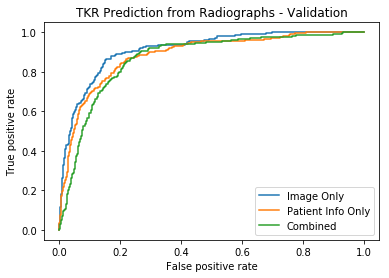

In [29]:
# plot ROC curve (without bootstrapped samples) and show bootstrapped CI AUC
fpr_im
tpr_im

fpr_both = auc_data[0][0]
tpr_both = auc_data[0][1]

fpr_pt = auc_data[1][0]
tpr_pt = auc_data[1][1]

plt.plot(fpr_im,tpr_im,label = 'Image Only')
plt.plot(fpr_pt,tpr_pt, label = 'Patient Info Only')
plt.plot(fpr_both,tpr_both,label = 'Combined')
plt.title('TKR Prediction from Radiographs - Validation')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'lower right')

plt.show()

In [30]:
print('AUCs')
print('Image only       : '+str(round(np.mean(AUC_performance_val),4))+' +/- '+str(round(st.norm.ppf(.975)*np.std(AUC_performance_val),4))+', p < 0.05')
print('Patient info only: '+str(round(AUC_performance_full[1][0],4))+' +/- '+str(round(st.norm.ppf(.975)*AUC_performance_full[1][1],4))+', p < 0.05')
print('Combined         : '+str(round(AUC_performance_full[0][0],4))+' +/- '+str(round(st.norm.ppf(.975)*AUC_performance_full[0][1],4))+', p < 0.05')

AUCs
Image only       : 0.9144 +/- 0.0188, p < 0.05
Patient info only: 0.8859 +/- 0.0227, p < 0.05
Combined         : 0.8688 +/- 0.0206, p < 0.05


In [31]:
print('Test data full performance table')
full = np.zeros([6*3,8])
ind = []
for i in range(6):
    full[3*i,:] = storage_dfs[6].values[i,:]
    full[3*i+1,:] = performance_kl_df_img_test.values[i,:]
    full[3*i+2,:] = storage_dfs[4].values[i,:]
    full[3*i:3*i+3,0:6] = full[3*i:3*i+3,0:6] * 100
    if i < 5:
        ind.append('KL = '+str(i)+' - Patient Only')
        ind.append('KL = '+str(i)+' - Image Only')
        ind.append('KL = '+str(i)+' - Combined')
    else:
        ind.append('All - Patient Only')
        ind.append('All - Image Only')
        ind.append('All - Combined')

full = pd.DataFrame(data = full)

full.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']


full.index = ind

full

Test data full performance table


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  \
KL = 0 - Patient Only  90.375145  0.068370      21.9035   2.074533   
KL = 0 - Image Only    95.582427  0.045985      18.3884   2.042240   
KL = 0 - Combined      84.836746  0.075552      75.7866   2.606801   
KL = 1 - Patient Only  86.671008  0.114390      71.0373   1.952731   
KL = 1 - Image Only    94.151466  0.088865     100.0000   0.000000   
KL = 1 - Combined      78.156536  0.126335     100.0000   0.000000   
KL = 2 - Patient Only  77.147409  0.116635      50.2214   1.250042   
KL = 2 - Image Only    78.784555  0.119306      62.0164   1.212071   
KL = 2 - Combined      84.222245  0.095493      60.1232   1.084794   
KL = 3 - Patient Only  64.759071  0.163189      76.1684   0.567012   
KL = 3 - Image Only    51.108091  0.189293      84.1350   0.401733   
KL = 3 - Combined      58.401523  0.177371      84.2584   0.475398   
KL = 4 - Patient Only  51.863217  0.348712      89.1048   0.389385   
KL = 4 - Image Only    34.385181  0.343642      98.1055   0.162663   
KL = 4 - Combined      59.777582  0.327605      83.4165   0.446344   
All - Patient Only     81.026522  0.057152      75.8270   0.346605   
All - Image Only       82.116199  0.056316      84.9265   0.303983   
All - Combined         78.622591  0.054099      81.3622   0.288340   

                       Specificity  Spec.Std.  Non_TKR    TKR  
KL = 0 - Patient Only      90.5359   0.067380   1930.0    5.0  
KL = 0 - Image Only        95.7794   0.046272   1930.0    5.0  
KL = 0 - Combined          84.8510   0.076455   1930.0    5.0  
KL = 1 - Patient Only      86.7830   0.112814    962.0    7.0  
KL = 1 - Image Only        94.1110   0.089485    962.0    7.0  
KL = 1 - Combined          78.0034   0.127310    962.0    7.0  
KL = 2 - Patient Only      77.5482   0.115920   1354.0   20.0  
KL = 2 - Image Only        79.0351   0.122247   1354.0   20.0  
KL = 2 - Combined          84.5749   0.095032   1354.0   20.0  
KL = 3 - Patient Only      63.7468   0.163797    702.0   63.0  
KL = 3 - Image Only        48.0958   0.193074    702.0   63.0  
KL = 3 - Combined          56.0020   0.181147    702.0   63.0  
KL = 4 - Patient Only      36.5537   0.402393    141.0   57.0  
KL = 4 - Image Only         8.9428   0.240727    141.0   57.0  
KL = 4 - Combined          49.8840   0.411852    141.0   57.0  
All - Patient Only         81.1822   0.056297   5089.0  152.0  
All - Image Only           82.0334   0.058640   5089.0  152.0  
All - Combined             78.5381   0.054714   5089.0  152.0

In [32]:
print('Test data full performance table')
full = np.zeros([4*3,8])
ind = []
descriptions = ['None','Moderate','Severe']
for i in range(4):
    full[3*i,:] = storage_dfs[7].values[i,:]
    full[3*i+1,:] = performance_oa_df_img_test.values[i,:]
    full[3*i+2,:] = storage_dfs[5].values[i,:]
    full[3*i:3*i+3,0:6] = full[3*i:3*i+3,0:6] * 100
    if i < 3:
        ind.append(descriptions[i]+' - Patient Only')
        ind.append(descriptions[i]+' - Image Only')
        ind.append(descriptions[i]+' - Combined')
    else:
        ind.append('All - Patient Only')
        ind.append('All - Image Only')
        ind.append('All - Combined')

full = pd.DataFrame(data = full)
full = full.rename(columns={"0": "Accuracy", "1": "Sensitivity", "2": "Specificity",
                            "3": "Non-TKR-Cases", "4": "TKR-Cases"})
full.columns = ['Accuracy','Acc.Std.','Sensitivity','Sens.Std.','Specificity','Spec.Std.',
                                'Non_TKR','TKR']


full.index = ind

full

Test data full performance table


Accuracy  Acc.Std.  Sensitivity  Sens.Std.  \
None - Patient Only      89.135372  0.063083    52.476416   1.594559   
None - Image Only        95.106154  0.045761    65.419348   1.441965   
None - Combined          82.604892  0.066209    91.091282   0.817661   
Moderate - Patient Only  72.717209  0.101914    69.857349   0.530311   
Moderate - Image Only    68.932819  0.104825    78.830582   0.421951   
Moderate - Combined      74.979597  0.099202    78.555215   0.422031   
Severe - Patient Only    51.863217  0.348712    89.104276   0.389366   
Severe - Image Only      34.385181  0.343642    98.105397   0.162685   
Severe - Combined        59.777582  0.327605    83.416693   0.446317   
All - Patient Only       81.026522  0.057152    75.827543   0.346653   
All - Image Only         82.116199  0.056316    84.926126   0.304023   
All - Combined           78.622591  0.054099    81.362505   0.288357   

                         Specificity  Spec.Std.  Non_TKR    TKR  
None - Patient Only        89.284255   0.061331   2892.0   12.0  
None - Image Only          95.225521   0.046207   2892.0   12.0  
None - Combined            82.569616   0.066698   2892.0   12.0  
Moderate - Patient Only    72.832182   0.101015   2056.0   83.0  
Moderate - Image Only      68.531455   0.110331   2056.0   83.0  
Moderate - Combined        74.828642   0.100019   2056.0   83.0  
Severe - Patient Only      36.553897   0.402348    141.0   57.0  
Severe - Image Only         8.943154   0.240663    141.0   57.0  
Severe - Combined          49.884001   0.411866    141.0   57.0  
All - Patient Only         81.181987   0.056271   5089.0  152.0  
All - Image Only           82.033113   0.058640   5089.0  152.0  
All - Combined             78.538042   0.054755   5089.0  152.0

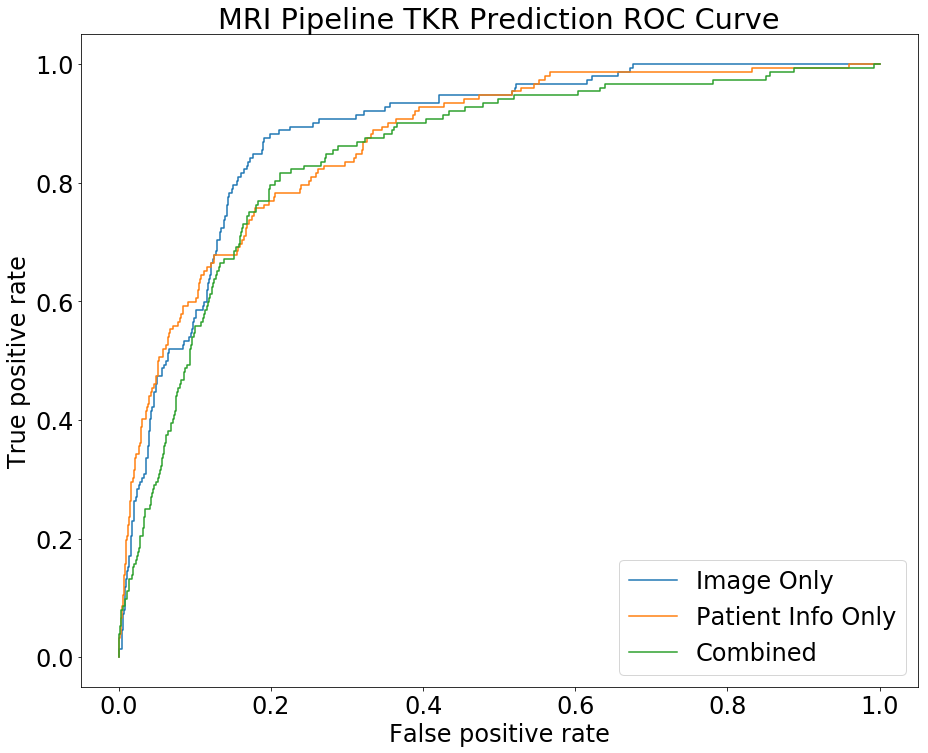

In [33]:
fpr_im_test
tpr_im_test

fpr_both_test = auc_data[2][0]
tpr_both_test = auc_data[2][1]

fpr_pt_test = auc_data[3][0]
tpr_pt_test = auc_data[3][1]
plt.figure(figsize = (15,12))

font = {'family' : 'sans-serif',
        'weight' : 'roman',
        'size'   : 24}

plt.rc('font', **font)
plt.plot(fpr_im_test,tpr_im_test,label = 'Image Only')
plt.plot(fpr_pt_test,tpr_pt_test, label = 'Patient Info Only')
plt.plot(fpr_both_test,tpr_both_test,label = 'Combined')
plt.title('MRI Pipeline TKR Prediction ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'lower right')


plt.show()

In [34]:
print('AUCs')
print('Image only       : '+str(round(np.mean(AUC_performance_test),4))+' +/- '+str(round(st.norm.ppf(.975)*np.std(AUC_performance_test),4))+', p < 0.05')
print('Patient info only: '+str(round(AUC_performance_full[3][0],4))+' +/- '+str(round(st.norm.ppf(.975)*AUC_performance_full[3][1],4))+', p < 0.05')
print('Combined         : '+str(round(AUC_performance_full[2][0],4))+' +/- '+str(round(st.norm.ppf(.975)*AUC_performance_full[2][1],4))+', p < 0.05')

AUCs
Image only       : 0.8852 +/- 0.0258, p < 0.05
Patient info only: 0.8701 +/- 0.027, p < 0.05
Combined         : 0.8467 +/- 0.0302, p < 0.05


In [35]:
# select bootstrapped AUCs with central AUC values (i.e. take just the central 68% of AUCs, based on thres);
# store the raw data from these AUCs in a dataframe and save
mri_full = []
thres = 16

ind = np.intersect1d(np.where(roc_raw_data_test[2] > np.percentile(roc_raw_data_test[2],thres))[0],np.where(roc_raw_data_test[2] < np.percentile(roc_raw_data_test[2],100-thres))[0])
for i in range(len(ind)):
    mri_full.append(roc_raw_data_test[0][ind[i]])
    
for i in range(len(ind)):
    mri_full.append(roc_raw_data_test[1][ind[i]])
    
ind = np.intersect1d(np.where(roc_raw_data_patient[2] > np.percentile(roc_raw_data_patient[2],thres))[0],np.where(roc_raw_data_patient[2] < np.percentile(roc_raw_data_patient[2],100-thres))[0])
for i in range(len(ind)):
    mri_full.append(roc_raw_data_patient[0][ind[i]])
    
for i in range(len(ind)):
    mri_full.append(roc_raw_data_patient[1][ind[i]])
    
ind = np.intersect1d(np.where(roc_raw_data_combined[2] > np.percentile(roc_raw_data_combined[2],thres))[0],np.where(roc_raw_data_combined[2] < np.percentile(roc_raw_data_combined[2],100-thres))[0])
for i in range(len(ind)):
    mri_full.append(roc_raw_data_combined[0][ind[i]])
    
for i in range(len(ind)):
    mri_full.append(roc_raw_data_combined[1][ind[i]])
    
df = pd.DataFrame(data = mri_full)
df.shape

(408, 2020)

In [ ]:
df.to_csv(os.path.join(os.getcwd()[:-3],'ROC_Figure_Files/MRI_CI_ROC_data_post_review.csv'))

In [37]:
# Look at the ROC curves calculated on the entirety of all relevant models (not bootstrapped), and store
# and save as a dataframe
data_im = {'Image_FPR': fpr_im_test, 'Image_TPR': tpr_im_test}
data_pt = {'Patient_FPR':fpr_pt_test,'Patient_TPR':tpr_pt_test}
data_cb = {'Comb_FPR':fpr_both_test,'Comb_TPR':tpr_both_test}

df_im = pd.DataFrame(data = data_im)
df_pt = pd.DataFrame(data = data_pt)
df_cb = pd.DataFrame(data = data_cb)

full_df = pd.concat([df_im,df_pt,df_cb],ignore_index = True,axis = 1)

full_df.columns = ['Image_FPR','Image_TPR','Patient_FPR','Patient_TPR','Comb_FPR','Comb_TPR']
full_df

Image_FPR  Image_TPR  Patient_FPR  Patient_TPR  Comb_FPR  Comb_TPR
0     0.000000   0.000000     0.000000     0.000000  0.000000  0.000000
1     0.000000   0.006579     0.000000     0.006579  0.000000  0.006579
2     0.000393   0.006579     0.000000     0.013158  0.000000  0.019737
3     0.000393   0.013158     0.000393     0.013158  0.000393  0.019737
4     0.004127   0.013158     0.000393     0.019737  0.000393  0.026316
5     0.004127   0.026316     0.000590     0.019737  0.000786  0.026316
6     0.004323   0.026316     0.000590     0.026316  0.000786  0.032895
7     0.004323   0.039474     0.000983     0.026316  0.000983  0.032895
8     0.004913   0.039474     0.000983     0.032895  0.000983  0.039474
9     0.004913   0.046053     0.002162     0.032895  0.001376  0.039474
10    0.005306   0.046053     0.002162     0.039474  0.001376  0.046053
11    0.005306   0.065789     0.002555     0.039474  0.001572  0.046053
12    0.006092   0.065789     0.002555     0.052632  0.001572  0.052632
13    0.006092   0.072368     0.003341     0.052632  0.002358  0.052632
14    0.006288   0.072368     0.003341     0.065789  0.002358  0.065789
15    0.006288   0.078947     0.003734     0.065789  0.002751  0.065789
16    0.007664   0.078947     0.003734     0.078947  0.002751  0.078947
17    0.007664   0.085526     0.004520     0.078947  0.005699  0.078947
18    0.007860   0.085526     0.004520     0.085526  0.005699  0.085526
19    0.007860   0.098684     0.005502     0.085526  0.007664  0.085526
20    0.008253   0.098684     0.005502     0.092105  0.007664  0.092105
21    0.008253   0.111842     0.005699     0.092105  0.008843  0.092105
22    0.008646   0.111842     0.005699     0.098684  0.008843  0.098684
23    0.008646   0.118421     0.006092     0.098684  0.010611  0.098684
24    0.009432   0.118421     0.006092     0.105263  0.010611  0.111842
25    0.009432   0.125000     0.006288     0.105263  0.013755  0.111842
26    0.009825   0.125000     0.006288     0.111842  0.013755  0.131579
27    0.009825   0.131579     0.006681     0.111842  0.016899  0.131579
28    0.010808   0.131579     0.006681     0.118421  0.016899  0.138158
29    0.010808   0.138158     0.007074     0.118421  0.018078  0.138158
..         ...        ...          ...          ...       ...       ...
262        NaN        NaN     0.560621     0.980263  0.780703  0.973684
263        NaN        NaN     0.566713     0.980263  0.850462  0.973684
264        NaN        NaN     0.566713     0.986842  0.850462  0.980263
265        NaN        NaN     0.619179     0.986842  0.855571  0.980263
266        NaN        NaN     0.619572     0.986842  0.855571  0.986842
267        NaN        NaN     0.672431     0.986842  0.887208  0.986842
268        NaN        NaN     0.672824     0.986842  0.887208  0.993421
269        NaN        NaN     0.679701     0.986842  0.992336  0.993421
270        NaN        NaN     0.680094     0.986842  0.992336  1.000000
271        NaN        NaN     0.790725     0.986842  1.000000  1.000000
272        NaN        NaN     0.791118     0.986842       NaN       NaN
273        NaN        NaN     0.825899     0.986842       NaN       NaN
274        NaN        NaN     0.826292     0.986842       NaN       NaN
275        NaN        NaN     0.831991     0.986842       NaN       NaN
276        NaN        NaN     0.831991     0.993421       NaN       NaN
277        NaN        NaN     0.859697     0.993421       NaN       NaN
278        NaN        NaN     0.860090     0.993421       NaN       NaN
279        NaN        NaN     0.875614     0.993421       NaN       NaN
280        NaN        NaN     0.876007     0.993421       NaN       NaN
281        NaN        NaN     0.889762     0.993421       NaN       NaN
282        NaN        NaN     0.890155     0.993421       NaN       NaN
283        NaN        NaN     0.942818     0.993421       NaN       NaN
284        NaN        NaN     0.943211     0.993421       NaN       NaN
285        NaN        NaN     0.959128     0.

In [ ]:
full_df.to_csv(os.path.join(os.getcwd()[:-3],'ROC_Figure_Files/MRI_ROC_data_post_review.csv'))